## Part B. Multiclass Logistic Regression via One-vs-All (OvA)

**4. Dataset Use the Wine dataset (from sklearn.datasets import load_wine).**

In [ ]:
# There are 3 wine cultivars (classes) with 13 chemical features.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix,ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression

In [2]:
wine = load_wine(as_frame=True)
X = wine.data
y = wine.target

print(f"Shape of X: {X.shape}")
print(f"Unique classes: {np.unique(y)}")

Shape of X: (178, 13)
Unique classes: [0 1 2]


In [ ]:
# Standardize all features

In [3]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
#Add intercept column

In [4]:
X_scaled = np.c_[np.ones(X_scaled.shape[0]), X_scaled]

In [6]:
# Split. Use train/test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=20, stratify=y)

5. **OvA Implementation**


In [ ]:
# Build **three binary classifiers**, each distinguishing one class vs. all others.
# Use your binary logistic regression optimizer from Part A.

In [7]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def f(X, theta):
    return sigmoid(X.dot(theta))

def log_likelihood(theta, X, y):
    return (y*np.log(f(X, theta) + 1e-6) + (1-y)*np.log(1-f(X, theta) + 1e-6)).mean()

def loglik_gradient(theta, X, y):
    return np.mean((f(X, theta) - y) * X.T, axis=1)

def gradient_descent(X, y, lr=0.01, epochs=10000):
    m, n = X.shape
    theta = np.zeros(n)
    for _ in range(epochs):
        y_pred = sigmoid(X @ theta)
        gradient = (1/m) * X.T @ (y_pred - y)
        theta -= lr * gradient
    return theta

In [8]:
classes = np.unique(y_train)
theta_all = {}

print("Training OvA classifiers...")
for c in classes:
    y_binary = (y_train == c).astype(int)
    theta_c = gradient_descent(X_train, y_binary)
    theta_all[c] = theta_c
    print(f"Trained class {c}")

Training OvA classifiers...
Trained class 0
Trained class 1
Trained class 2


   * For prediction:

     * Compute probabilities from each classifier.
     * Assign each observation to the class with the highest predicted probability

In [9]:
#Function
def predict_ova(X, theta_all):
    probs = np.zeros((X.shape[0], len(theta_all)))
    for c, theta in theta_all.items():
        probs[:, c] = f(X, theta)
    return np.argmax(probs, axis=1), probs

# Predictions
y_pred_train, _ = predict_ova(X_train, theta_all)
y_pred_test, _ = predict_ova(X_test, theta_all)

   * Report confusion matrix and accuracy.

Test Accuracy:  0.9630

Confusion Matrix:


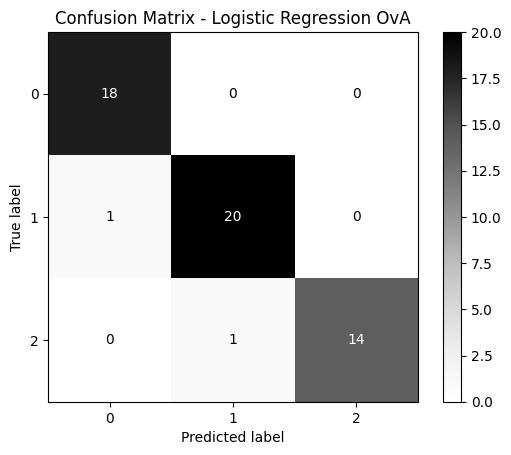

In [14]:
train_acc = accuracy_score(y_train, y_pred_train)
test_acc = accuracy_score(y_test, y_pred_test)
cm = confusion_matrix(y_test, y_pred_test)

#print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy:  {test_acc:.4f}")
print("\nConfusion Matrix:")
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0, 1, 2])
disp.plot(cmap='Greys', values_format='d')
plt.title("Confusion Matrix - Logistic Regression OvA")
plt.show()

Comment:
The OvA model achieved an accuracy of 96.30%, which demonstrates good effectiveness in distinguishing the three wine classes.
The confusion matrix shows that almost all observations were correctly classified, with only a small error in class 1.
In summary, this model shows good and accurate performance in multiclass prediction.

6. **Comparison**
   * Fit `LogisticRegression(multi_class="ovr")` from sklearn.
   * Compare coefficients and accuracy to your own implementation.
  

In [13]:
#Using Sklearn
sk_model = LogisticRegression(multi_class="ovr", max_iter=10000, random_state=20)
sk_model.fit(X_train[:, 1:], y_train)
y_pred_sk = sk_model.predict(X_test[:, 1:])

sk_acc = accuracy_score(y_test, y_pred_sk)

print("\nComparison with sklearn:")
print(f"Custom OvA Logistic Regression Accuracy: {test_acc:.4f}")
print(f"sklearn LogisticRegression(ovr) Accuracy: {sk_acc:.4f}")

# Compare coefficients
for c in classes:
    print(f"\nClass {c}")
    print(f"  Our coefficients: {theta_all[c][:5]}")
    print(f"  Sklearn coef:     {sk_model.coef_[c][:5]}")


Comparison with sklearn:
Custom OvA Logistic Regression Accuracy: 0.9630
sklearn LogisticRegression(ovr) Accuracy: 0.9630

Class 0
  Our coefficients: [-1.67207354  1.43241178  0.21855973  1.04948935 -1.23933799]
  Sklearn coef:     [ 1.11974665  0.13989642  0.81808585 -0.95956191  0.14618081]

Class 1
  Our coefficients: [-1.17341953 -1.83950597 -1.04007029 -1.24877814  0.58942787]
  Sklearn coef:     [-1.32630445 -0.77804247 -0.91608494  0.4281271  -0.06734354]

Class 2
  Our coefficients: [-2.82972921  0.47496192  0.70681189  0.56169167  0.46883102]
  Sklearn coef:     [0.53857279 0.75034606 0.59094583 0.44771088 0.16463422]


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Comment:

It is found that the accuracy value of 0.9630 is the same under both models, whether using OvA or LogisticRegression from Scikit-learn. However, it is observed that the coefficients are different.